In [ ]:
# LTSM Based on: https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

In [5]:
# dataset_grouped_by_hour_boolean
df = pd.read_csv(
  "../../dataset_grouped_by_hour_boolean.csv", 
  parse_dates=['timeFrom'], 
  index_col="timeFrom"
)
df

,isWeekday,isRain,isHoliday,TotalParkings
timeFrom,,,,
2013-01-01 07:00:00,1,0,1,13
2013-01-01 08:00:00,1,0,1,21
2013-01-01 09:00:00,1,0,1,16
2013-01-01 10:00:00,1,0,1,17
2013-01-01 11:00:00,1,0,1,18
...,...,...,...,...
2017-12-31 18:00:00,0,0,0,25
2017-12-31 19:00:00,0,0,0,22
2017-12-31 20:00:00,0,0,0,21


In [15]:
# Remove the time data from closed parking
df = df[df['TotalParkings'] > 0]
df

,isWeekday,isRain,isHoliday,TotalParkings,hour,day_of_month,day_of_week,month
timeFrom,,,,,,,,
2013-01-01 07:00:00,1,0,1,13,7,1,1,1
2013-01-01 08:00:00,1,0,1,21,8,1,1,1
2013-01-01 09:00:00,1,0,1,16,9,1,1,1
2013-01-01 10:00:00,1,0,1,17,10,1,1,1
2013-01-01 11:00:00,1,0,1,18,11,1,1,1
...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00,0,0,0,25,18,31,6,12
2017-12-31 19:00:00,0,0,0,22,19,31,6,12
2017-12-31 20:00:00,0,0,0,21,20,31,6,12


In [16]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

df

,isWeekday,isRain,isHoliday,TotalParkings,hour,day_of_month,day_of_week,month
timeFrom,,,,,,,,
2013-01-01 07:00:00,1,0,1,13,7,1,1,1
2013-01-01 08:00:00,1,0,1,21,8,1,1,1
2013-01-01 09:00:00,1,0,1,16,9,1,1,1
2013-01-01 10:00:00,1,0,1,17,10,1,1,1
2013-01-01 11:00:00,1,0,1,18,11,1,1,1
...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00,0,0,0,25,18,31,6,12
2017-12-31 19:00:00,0,0,0,22,19,31,6,12
2017-12-31 20:00:00,0,0,0,21,20,31,6,12


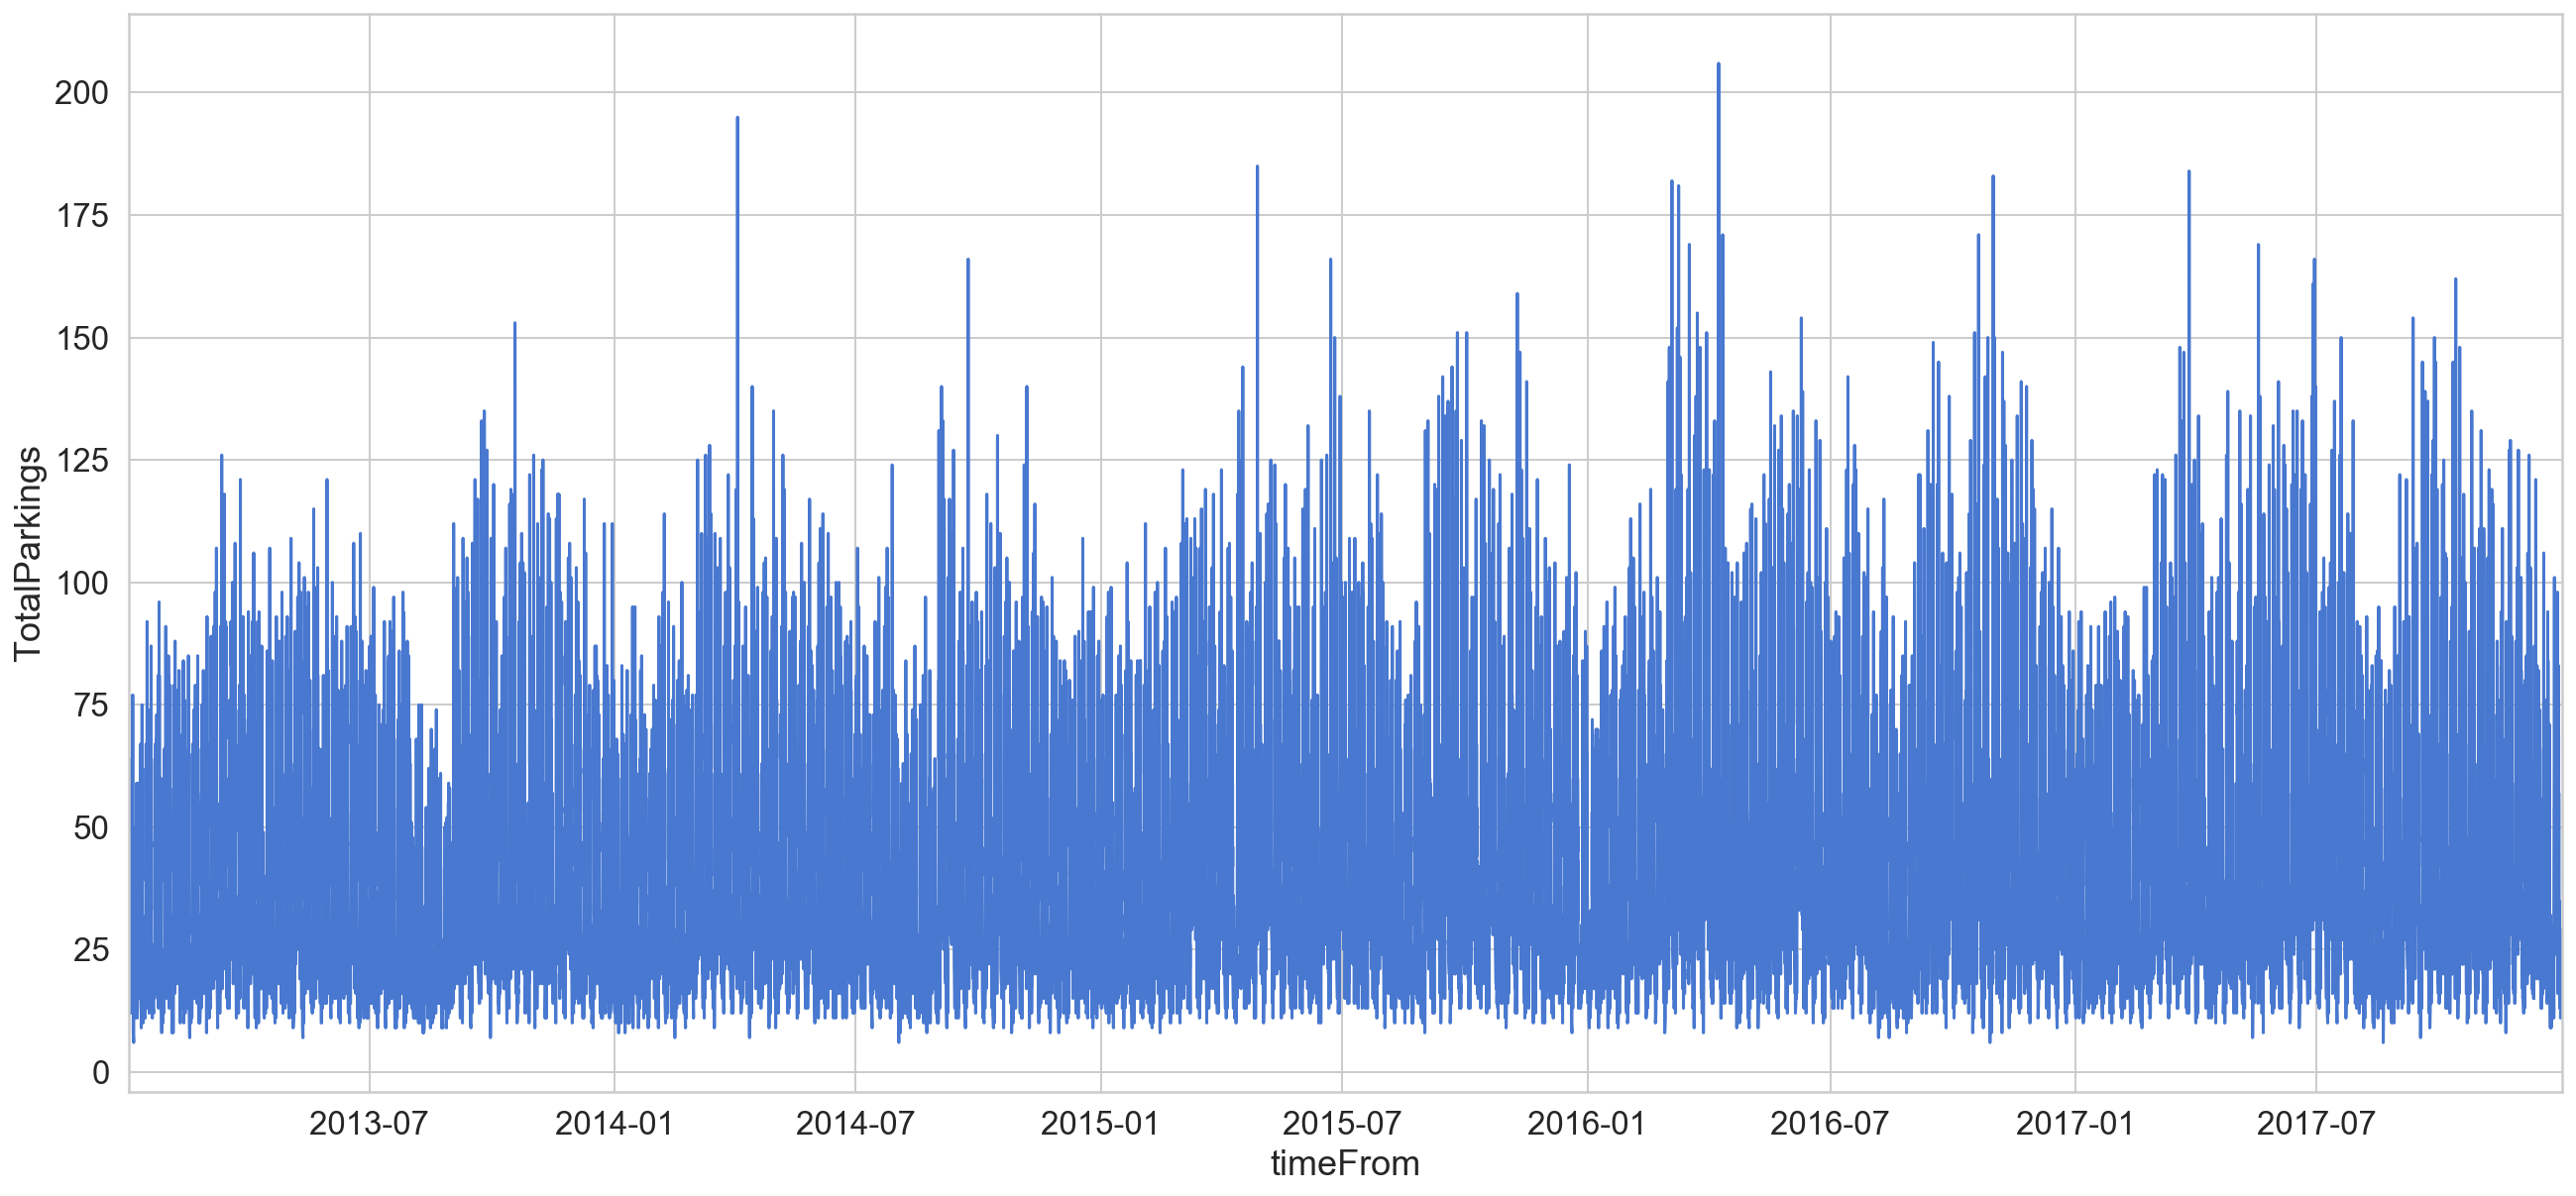

In [17]:
sns.lineplot(x=df.index, y="TotalParkings", data=df);
plt.margins(x=0)

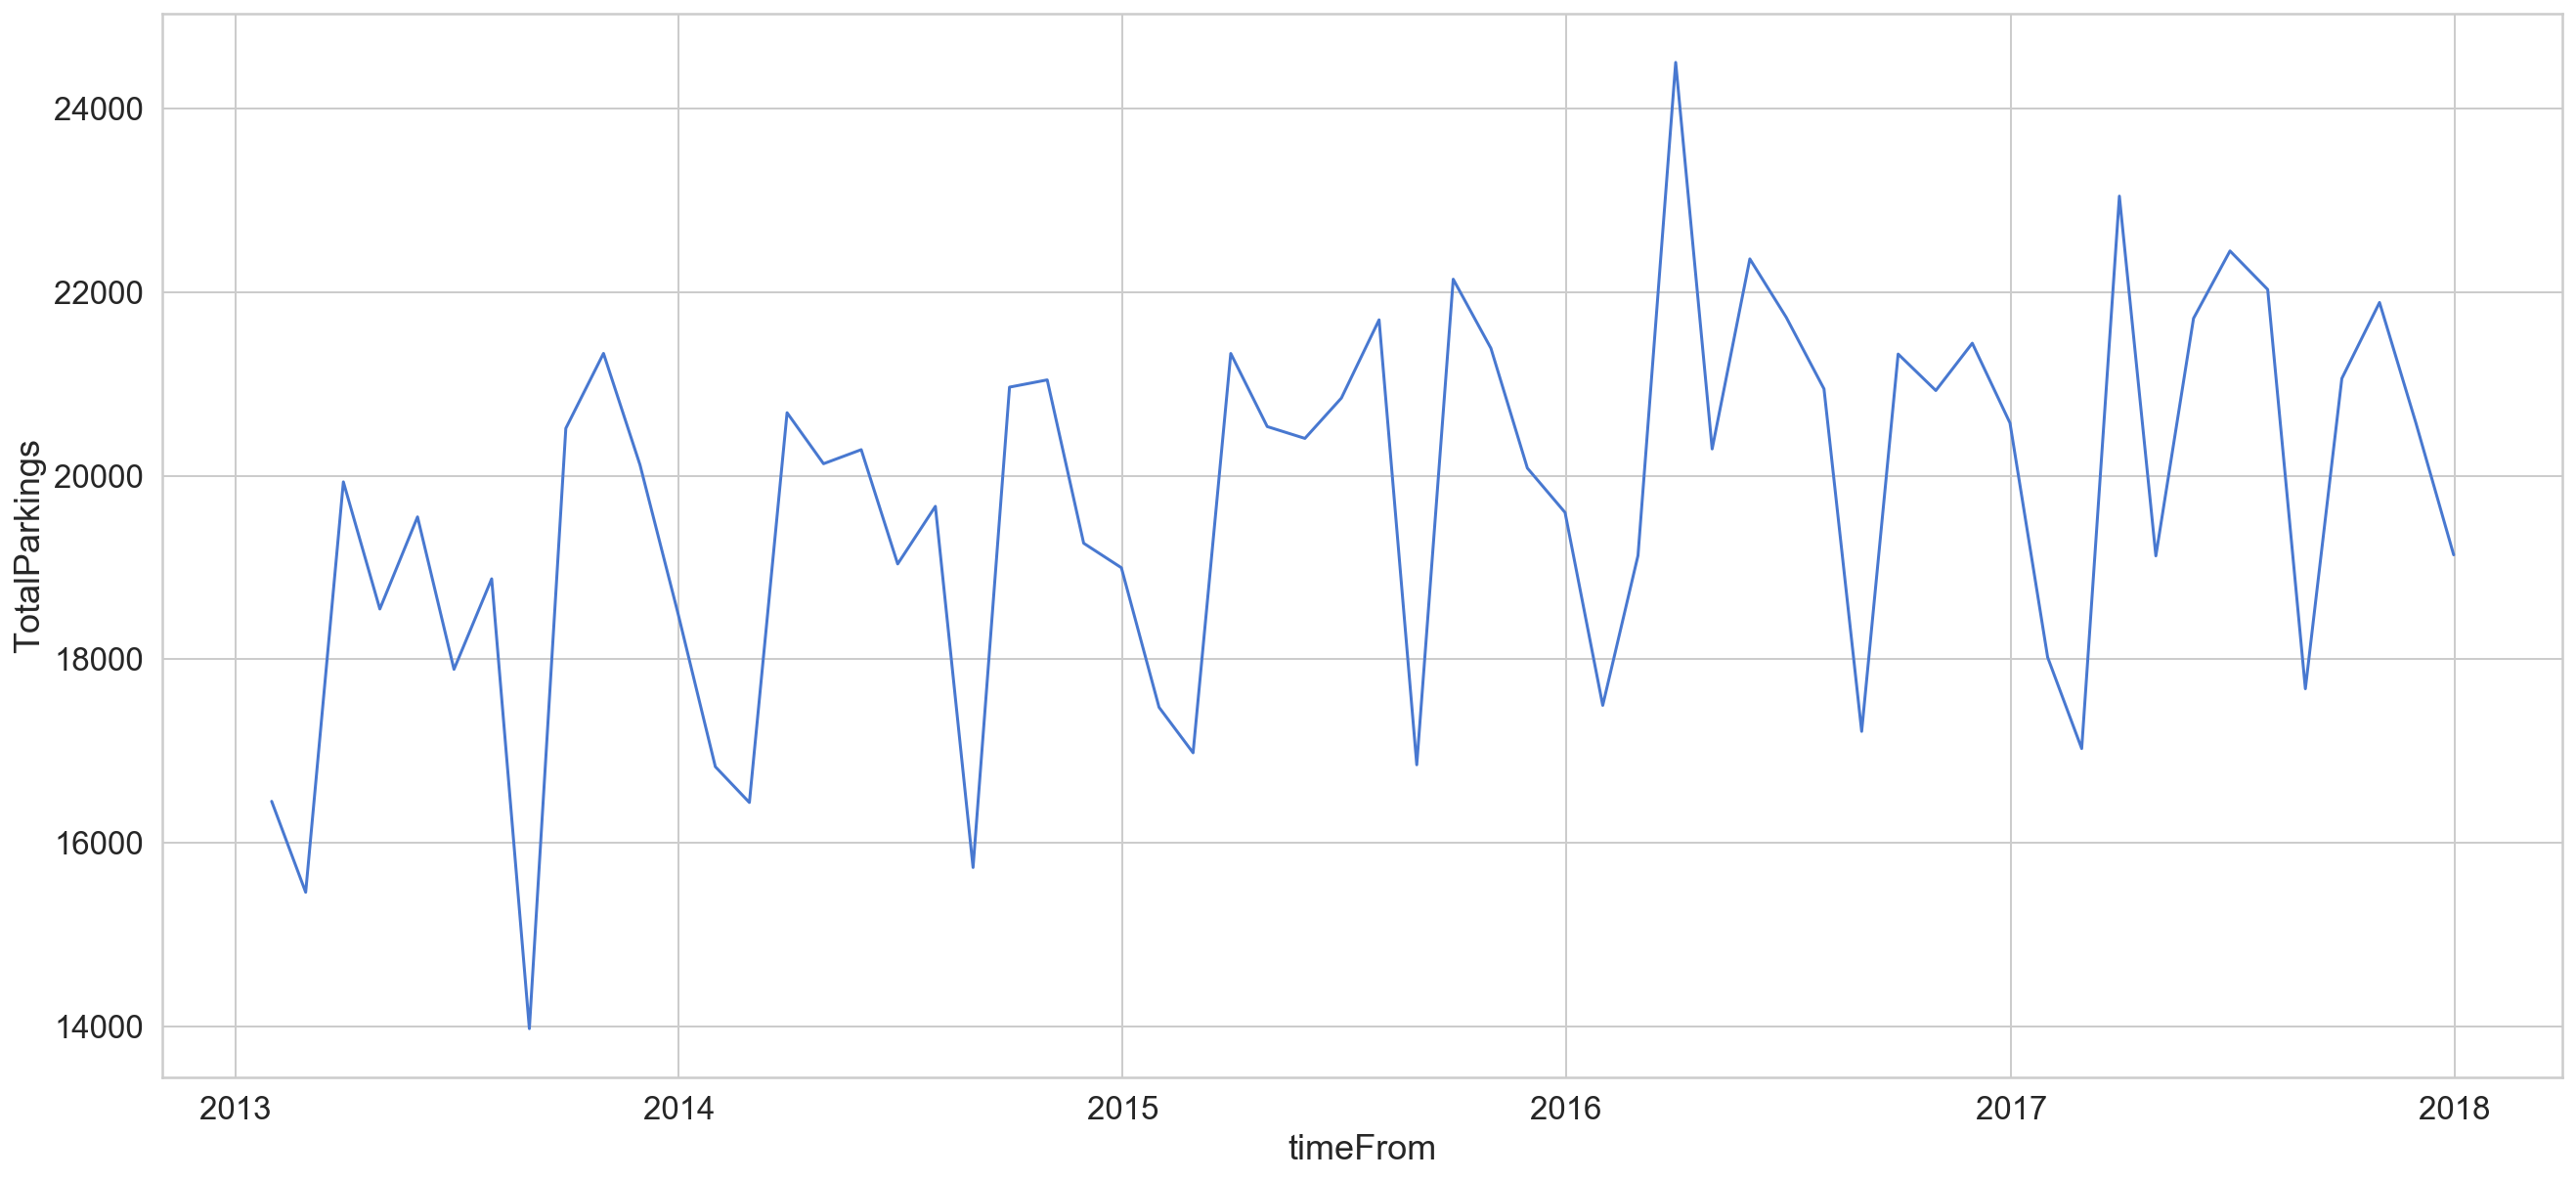

In [18]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="TotalParkings", data=df_by_month);

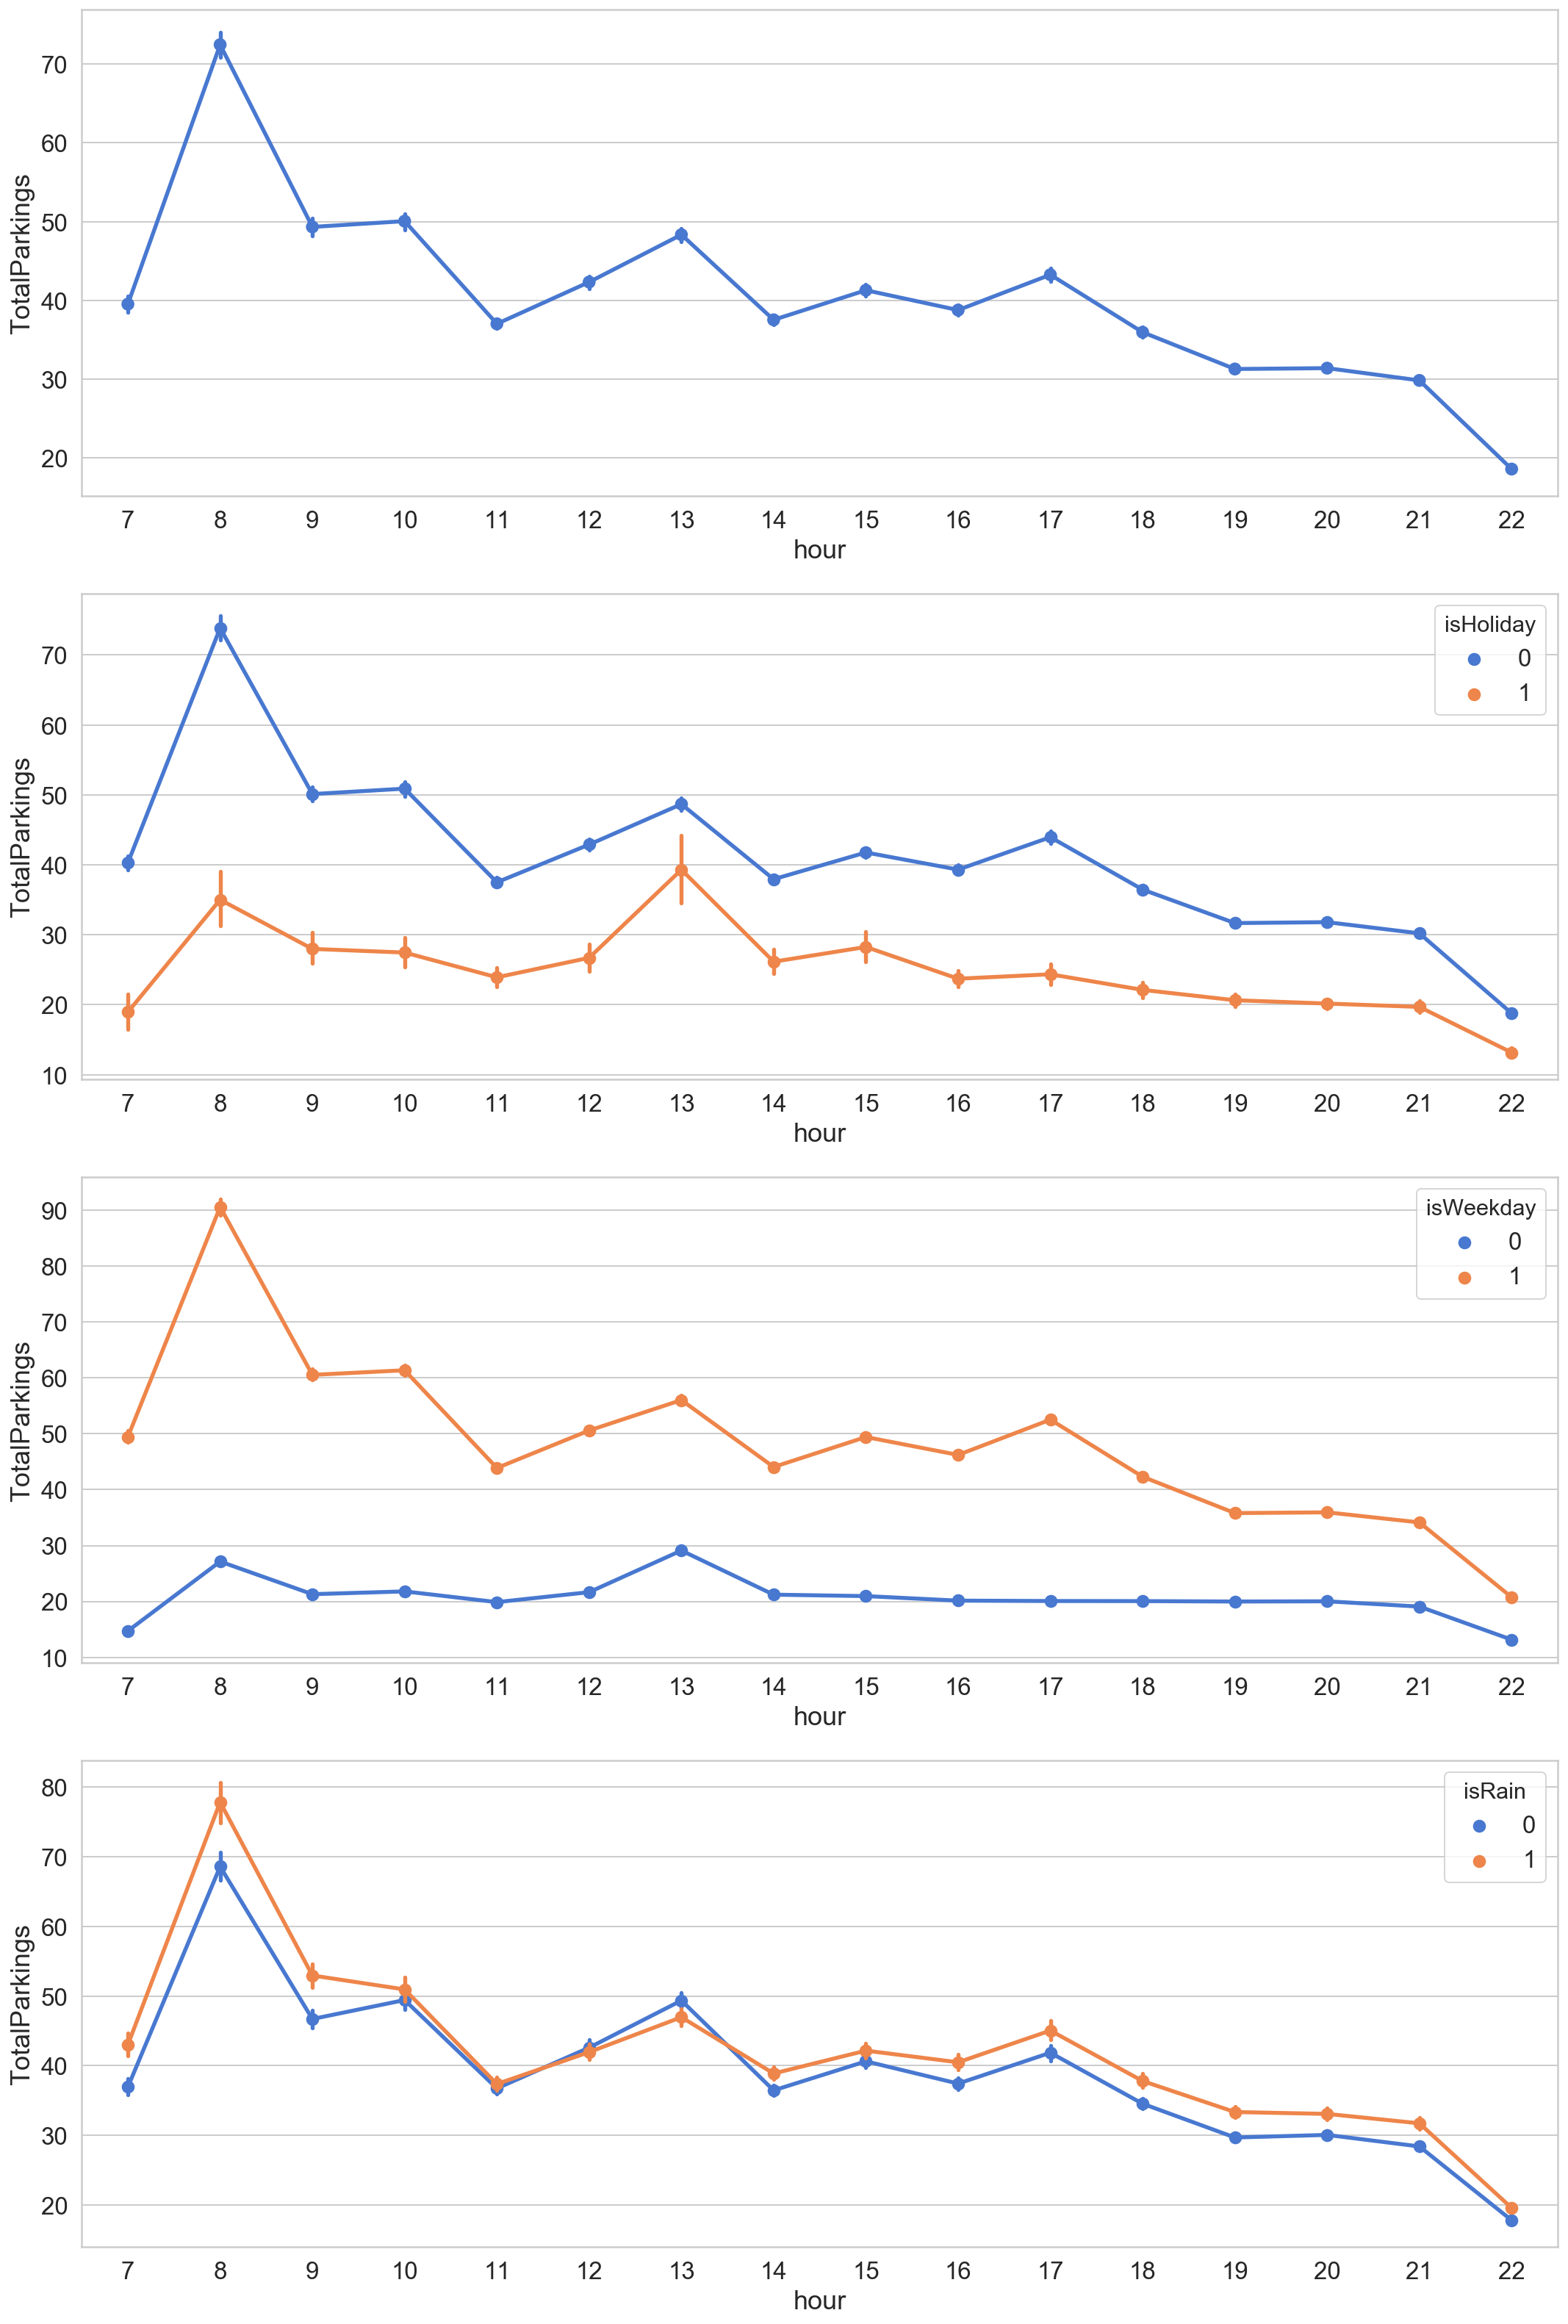

In [19]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='TotalParkings', ax=ax1)
sns.pointplot(data=df, x='hour', y='TotalParkings', hue='isHoliday', ax=ax2)
sns.pointplot(data=df, x='hour', y='TotalParkings', hue='isWeekday', ax=ax3)
sns.pointplot(data=df, x='hour', y='TotalParkings', hue='isRain', ax=ax4);

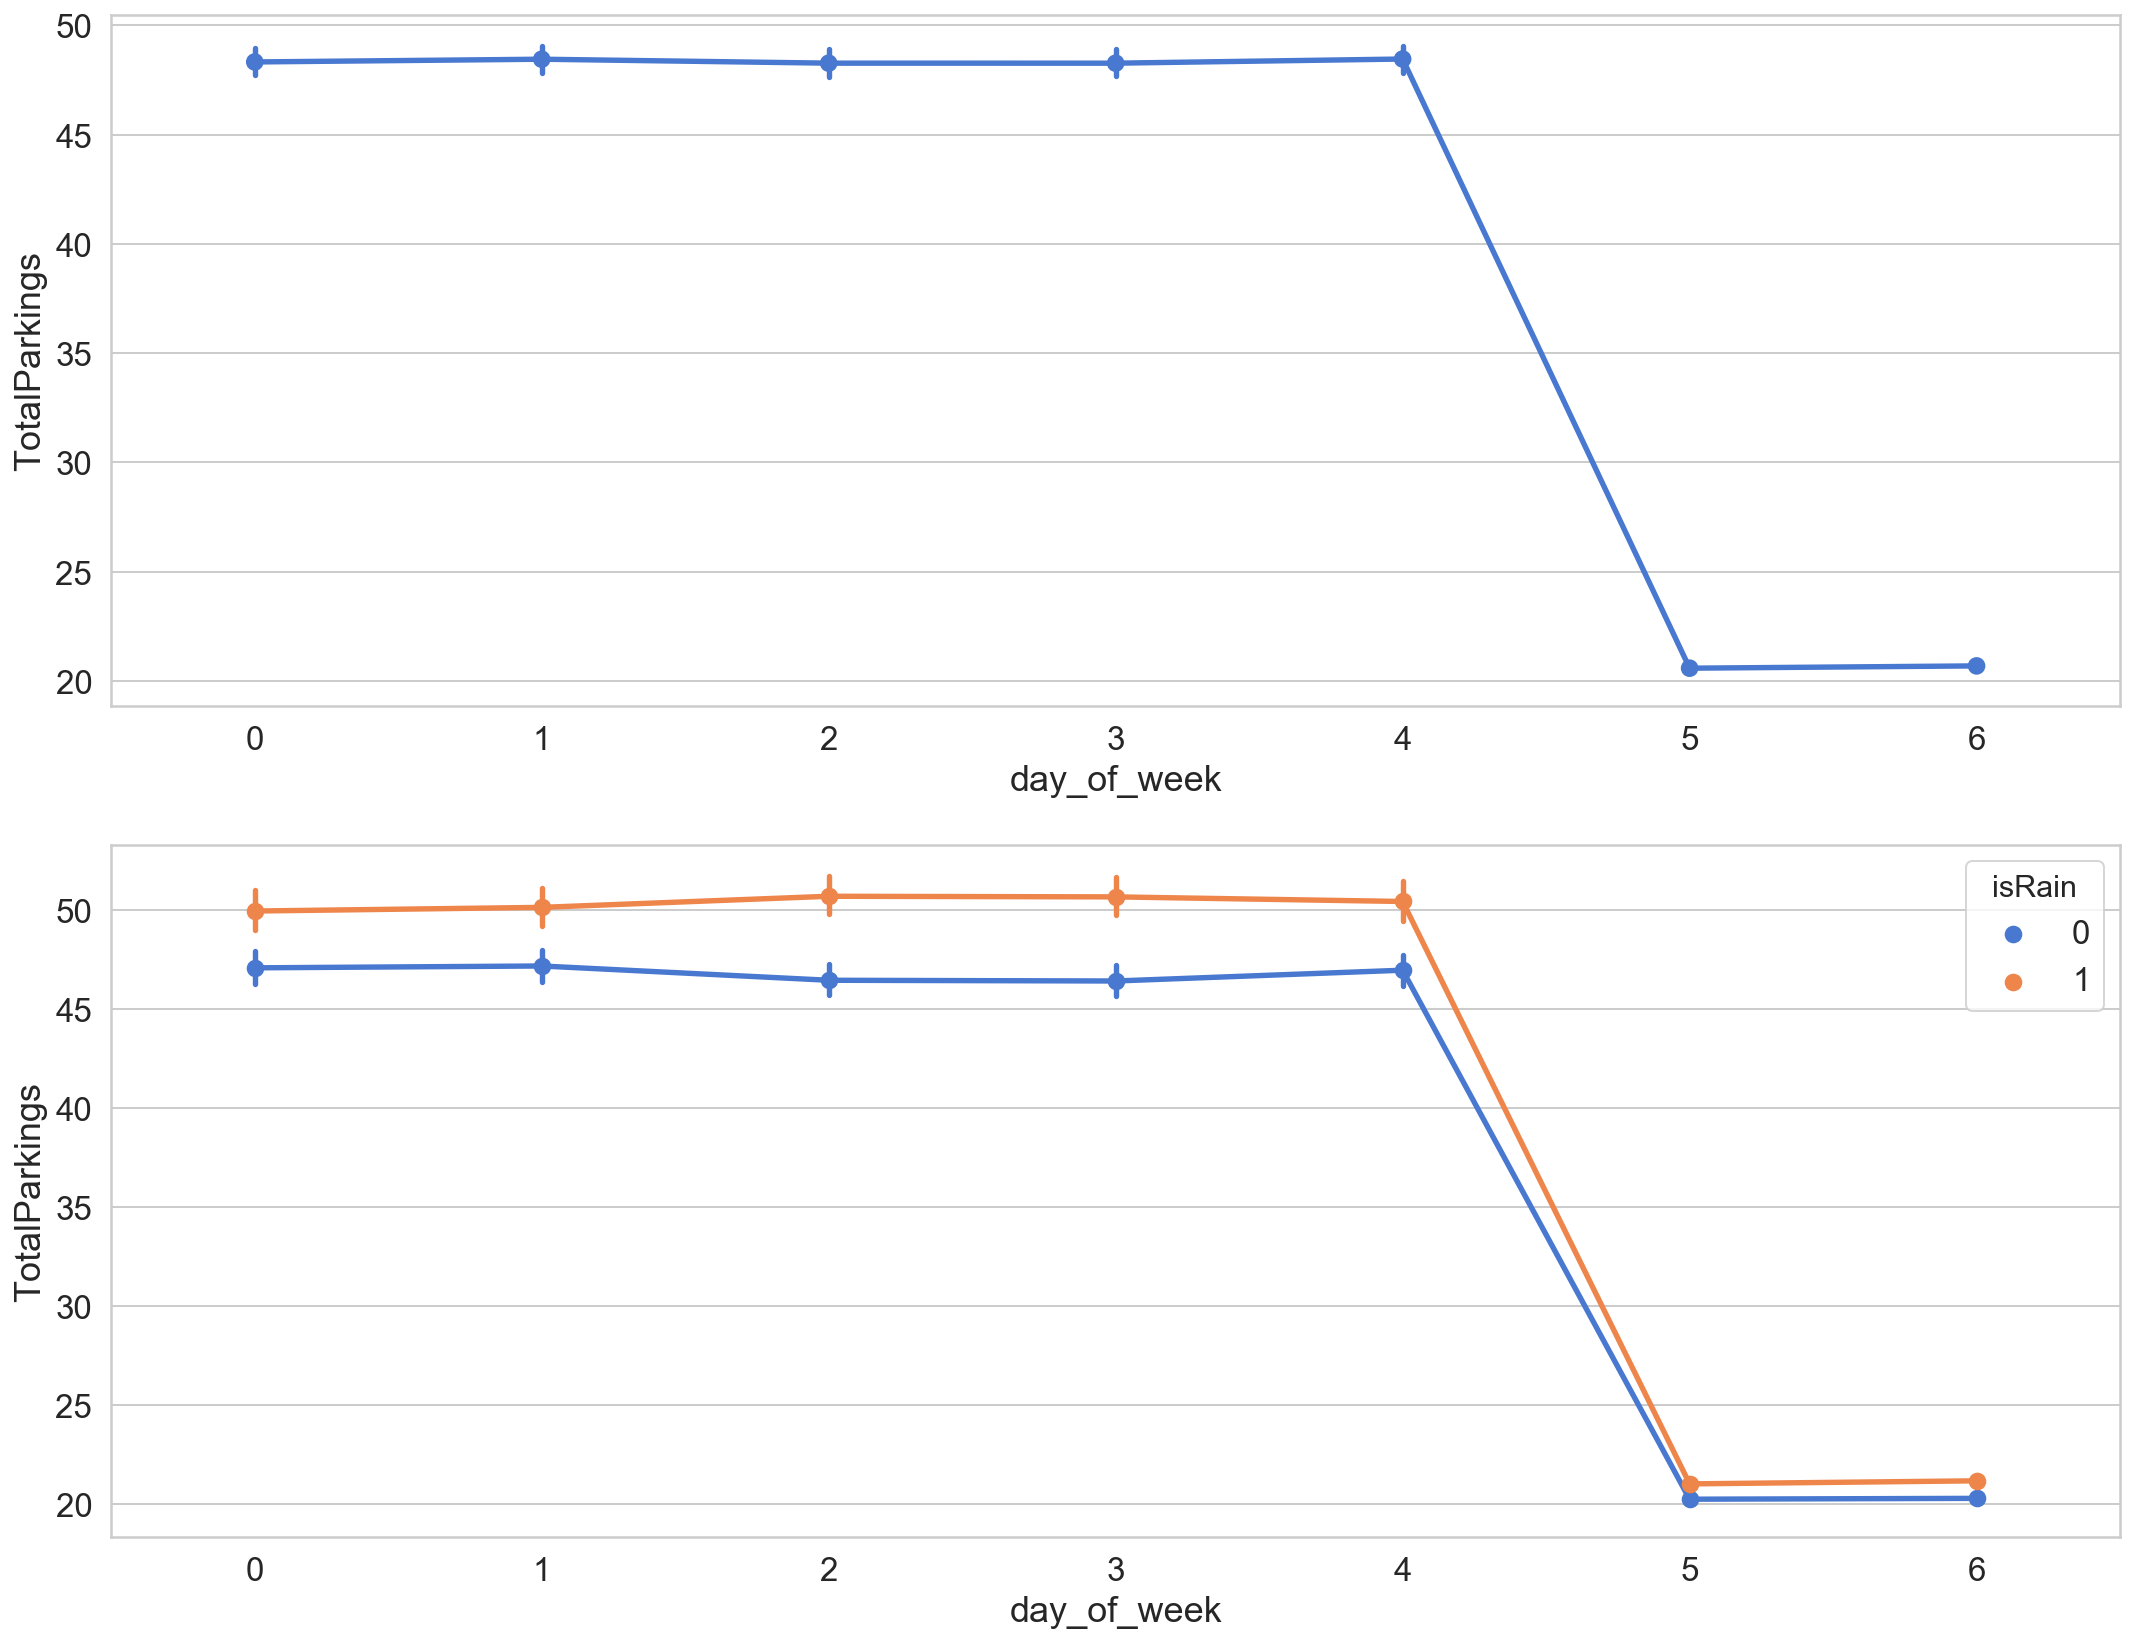

In [20]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='TotalParkings', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='TotalParkings', hue='isRain', ax=ax2);

In [23]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

26294 2922


In [106]:
from sklearn.preprocessing import RobustScaler

cnt_transformer = RobustScaler()

cnt_transformer = cnt_transformer.fit(train[['TotalParkings']])

train['TotalParkings'] = cnt_transformer.transform(train[['TotalParkings']])

test['TotalParkings'] = cnt_transformer.transform(test[['TotalParkings']])

print("DONE")

DONE


C:\Users\lrmen\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\lrmen\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [140]:
test

,isWeekday,isRain,isHoliday,TotalParkings,hour,day_of_month,day_of_week,month
timeFrom,,,,,,,,
2017-07-02 13:00:00,0,1,0,0.233333,13,2,6,7
2017-07-02 14:00:00,0,1,0,-0.500000,14,2,6,7
2017-07-02 15:00:00,0,1,0,-0.700000,15,2,6,7
2017-07-02 16:00:00,0,1,0,-0.533333,16,2,6,7
2017-07-02 17:00:00,0,1,0,-0.566667,17,2,6,7
...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00,0,0,0,-0.433333,18,31,6,12
2017-12-31 19:00:00,0,0,0,-0.533333,19,31,6,12
2017-12-31 20:00:00,0,0,0,-0.566667,20,31,6,12


In [141]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [142]:
time_steps = 16 #16 * 7

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.TotalParkings, time_steps)
X_test, y_test = create_dataset(test, test.TotalParkings, time_steps)

print(X_train.shape, y_train.shape)

(26278, 16, 8) (26278,)


In [127]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
print("DONE!")

DONE!


In [128]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 23650 samples, validate on 2628 samples
Epoch 1/500
23650/23650 [==============================] - 38s 2ms/sample - loss: 0.3343 - val_loss: 0.2083
Epoch 2/500
23650/23650 [==============================] - 33s 1ms/sample - loss: 0.1866 - val_loss: 0.2035
Epoch 3/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.1626 - val_loss: 0.2164
Epoch 4/500
23650/23650 [==============================] - 33s 1ms/sample - loss: 0.1528 - val_loss: 0.1899
Epoch 5/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.1428 - val_loss: 0.1788
Epoch 6/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.1336 - val_loss: 0.1633
Epoch 7/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.1289 - val_loss: 0.1593
Epoch 8/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.1233 - val_loss: 0.1629
Epoch 9/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.120

Epoch 76/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0643 - val_loss: 0.1264
Epoch 77/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0625 - val_loss: 0.1264
Epoch 78/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0643 - val_loss: 0.1285
Epoch 79/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0641 - val_loss: 0.1288
Epoch 80/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0638 - val_loss: 0.1297
Epoch 81/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0630 - val_loss: 0.1241
Epoch 82/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0615 - val_loss: 0.1367
Epoch 83/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0624 - val_loss: 0.1233
Epoch 84/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0599 - val_loss: 0.1277
Epoch 85/500
23650/

23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0428 - val_loss: 0.1350
Epoch 151/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0406 - val_loss: 0.1348
Epoch 152/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0399 - val_loss: 0.1342
Epoch 153/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0403 - val_loss: 0.1337
Epoch 154/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0396 - val_loss: 0.1335
Epoch 155/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0419 - val_loss: 0.1339
Epoch 156/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0395 - val_loss: 0.1289
Epoch 157/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0406 - val_loss: 0.1326
Epoch 158/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0387 - val_loss: 0.1385
Epoch 159/500
23650/2365

23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0311 - val_loss: 0.1319
Epoch 225/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0302 - val_loss: 0.1341
Epoch 226/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0307 - val_loss: 0.1359
Epoch 227/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0301 - val_loss: 0.1384
Epoch 228/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0322 - val_loss: 0.1392
Epoch 229/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0311 - val_loss: 0.1371
Epoch 230/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0302 - val_loss: 0.1332
Epoch 231/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0299 - val_loss: 0.1356
Epoch 232/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0303 - val_loss: 0.1336
Epoch 233/500
23650/2365

23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0252 - val_loss: 0.1351
Epoch 299/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0254 - val_loss: 0.1368
Epoch 300/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0251 - val_loss: 0.1315
Epoch 301/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0265 - val_loss: 0.1370
Epoch 302/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0273 - val_loss: 0.1359
Epoch 303/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0246 - val_loss: 0.1353
Epoch 304/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0262 - val_loss: 0.1386
Epoch 305/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0265 - val_loss: 0.1348
Epoch 306/500
23650/23650 [==============================] - 31s 1ms/sample - loss: 0.0261 - val_loss: 0.1346
Epoch 307/500
23650/2365

23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0228 - val_loss: 0.1352
Epoch 373/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0241 - val_loss: 0.1375
Epoch 374/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0223 - val_loss: 0.1318
Epoch 375/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0220 - val_loss: 0.1368
Epoch 376/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0249 - val_loss: 0.1323
Epoch 377/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0251 - val_loss: 0.1330
Epoch 378/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0228 - val_loss: 0.1324
Epoch 379/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0224 - val_loss: 0.1358
Epoch 380/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0231 - val_loss: 0.1302
Epoch 381/500
23650/2365

23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0218 - val_loss: 0.1340
Epoch 447/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0209 - val_loss: 0.1293
Epoch 448/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0206 - val_loss: 0.1311
Epoch 449/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0218 - val_loss: 0.1313
Epoch 450/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0216 - val_loss: 0.1329
Epoch 451/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0213 - val_loss: 0.1346
Epoch 452/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0233 - val_loss: 0.1320
Epoch 453/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0236 - val_loss: 0.1344
Epoch 454/500
23650/23650 [==============================] - 32s 1ms/sample - loss: 0.0213 - val_loss: 0.1333
Epoch 455/500
23650/2365

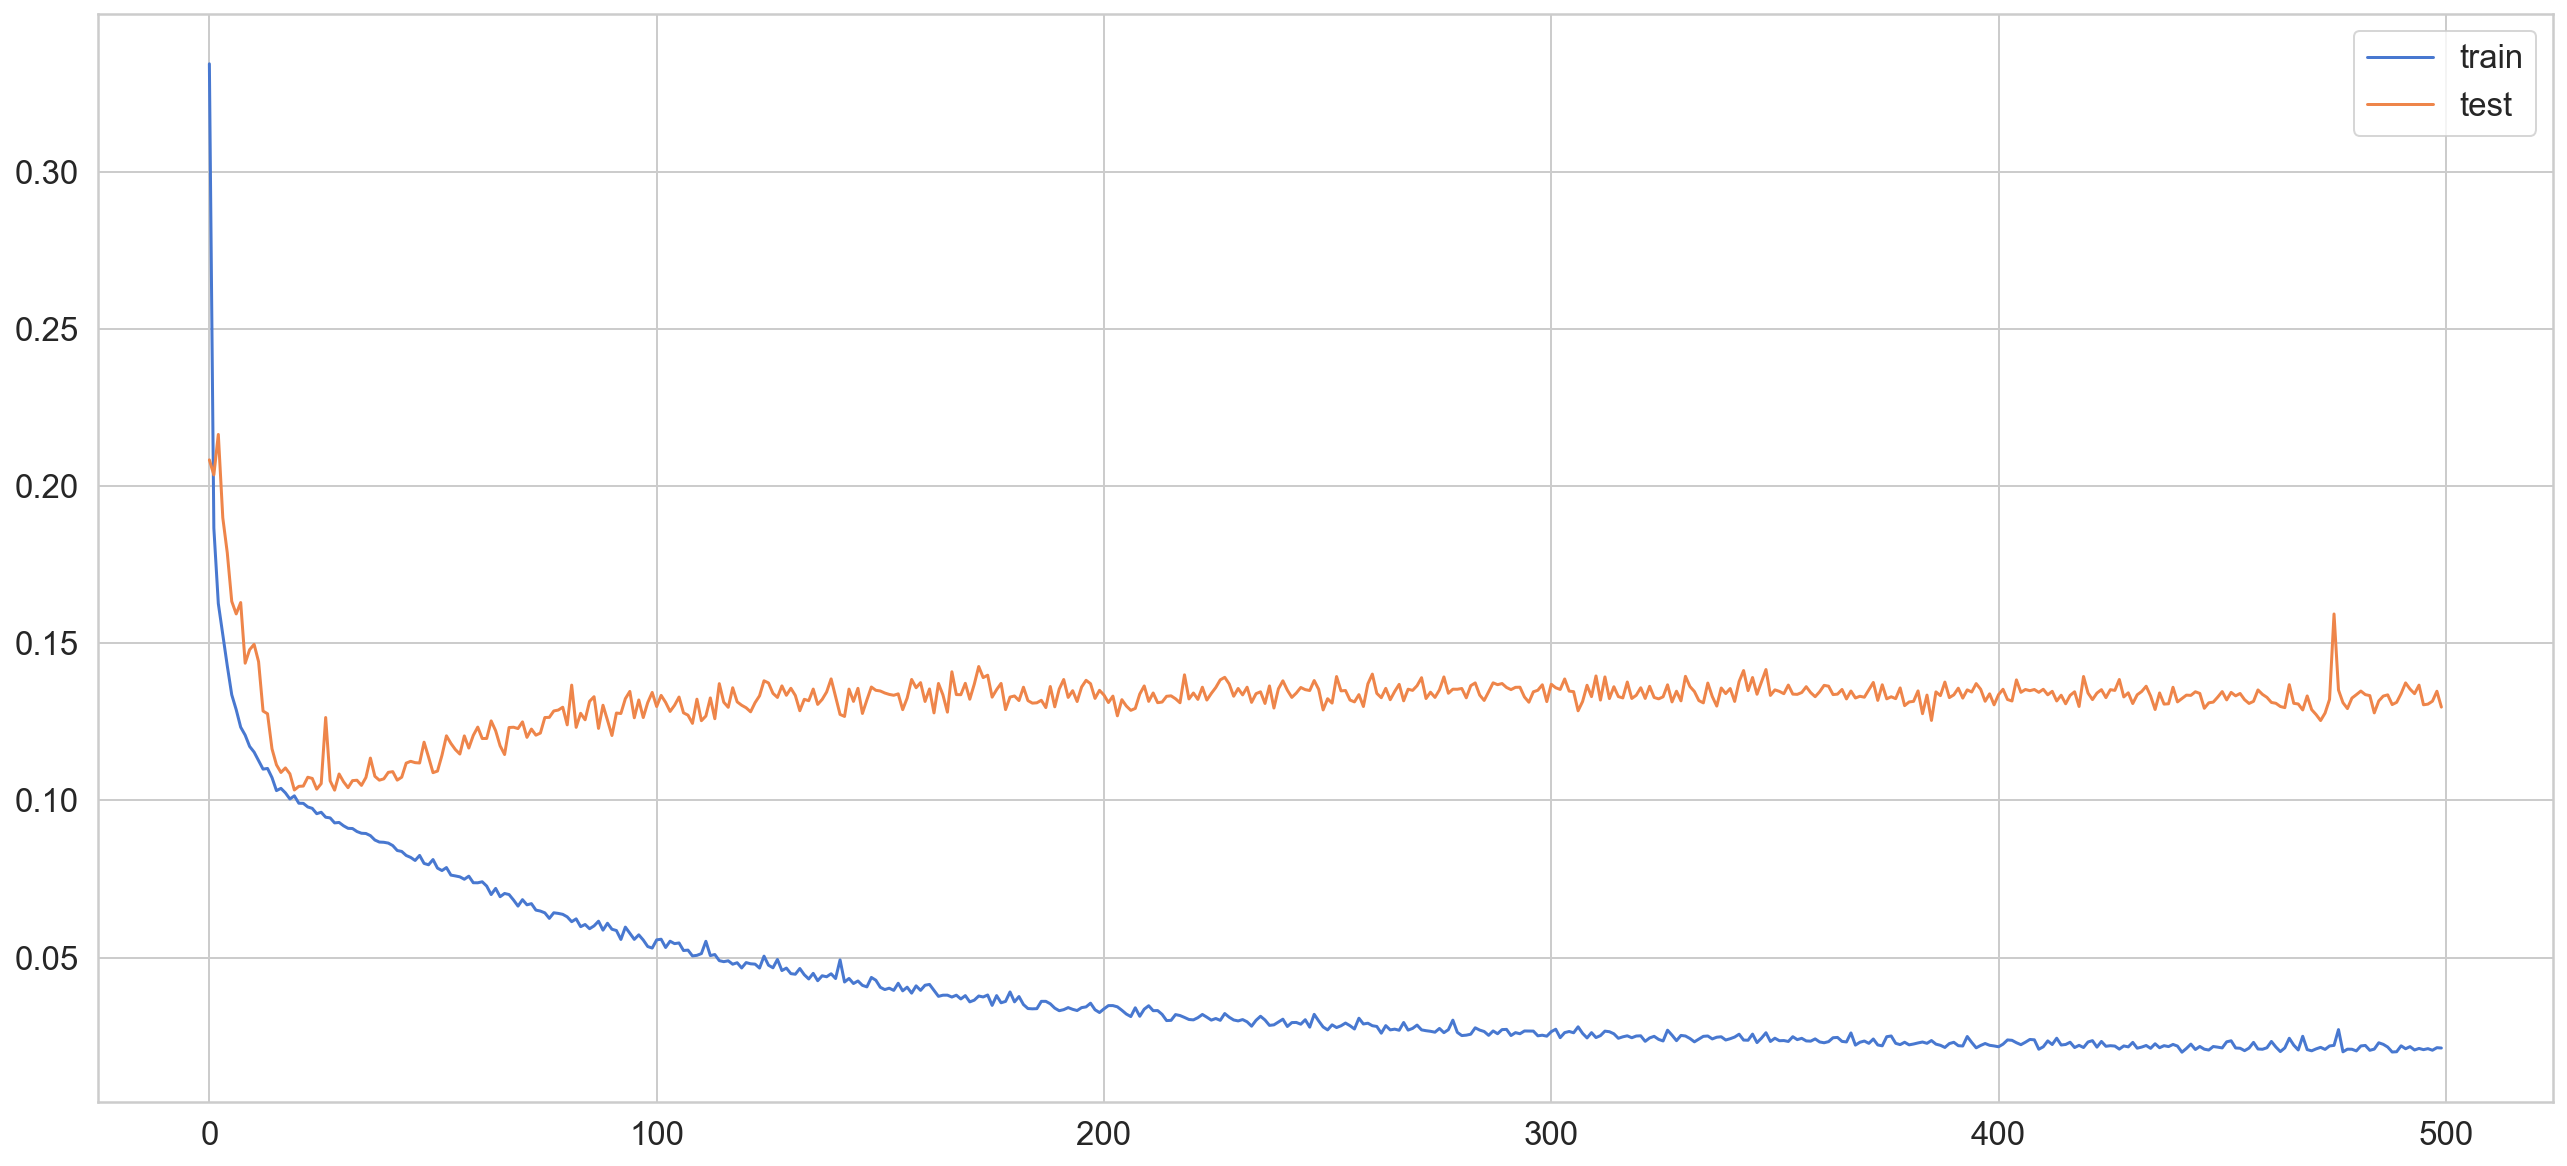

In [129]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [143]:
y_pred = model.predict(X_test)
y_pred

array([[-0.05536266],
       [ 0.13429147],
       [ 0.3911802 ],
       ...,
       [-0.67259306],
       [-0.6839339 ],
       [-0.85700005]], dtype=float32)

In [145]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
print("Done!")

Done!


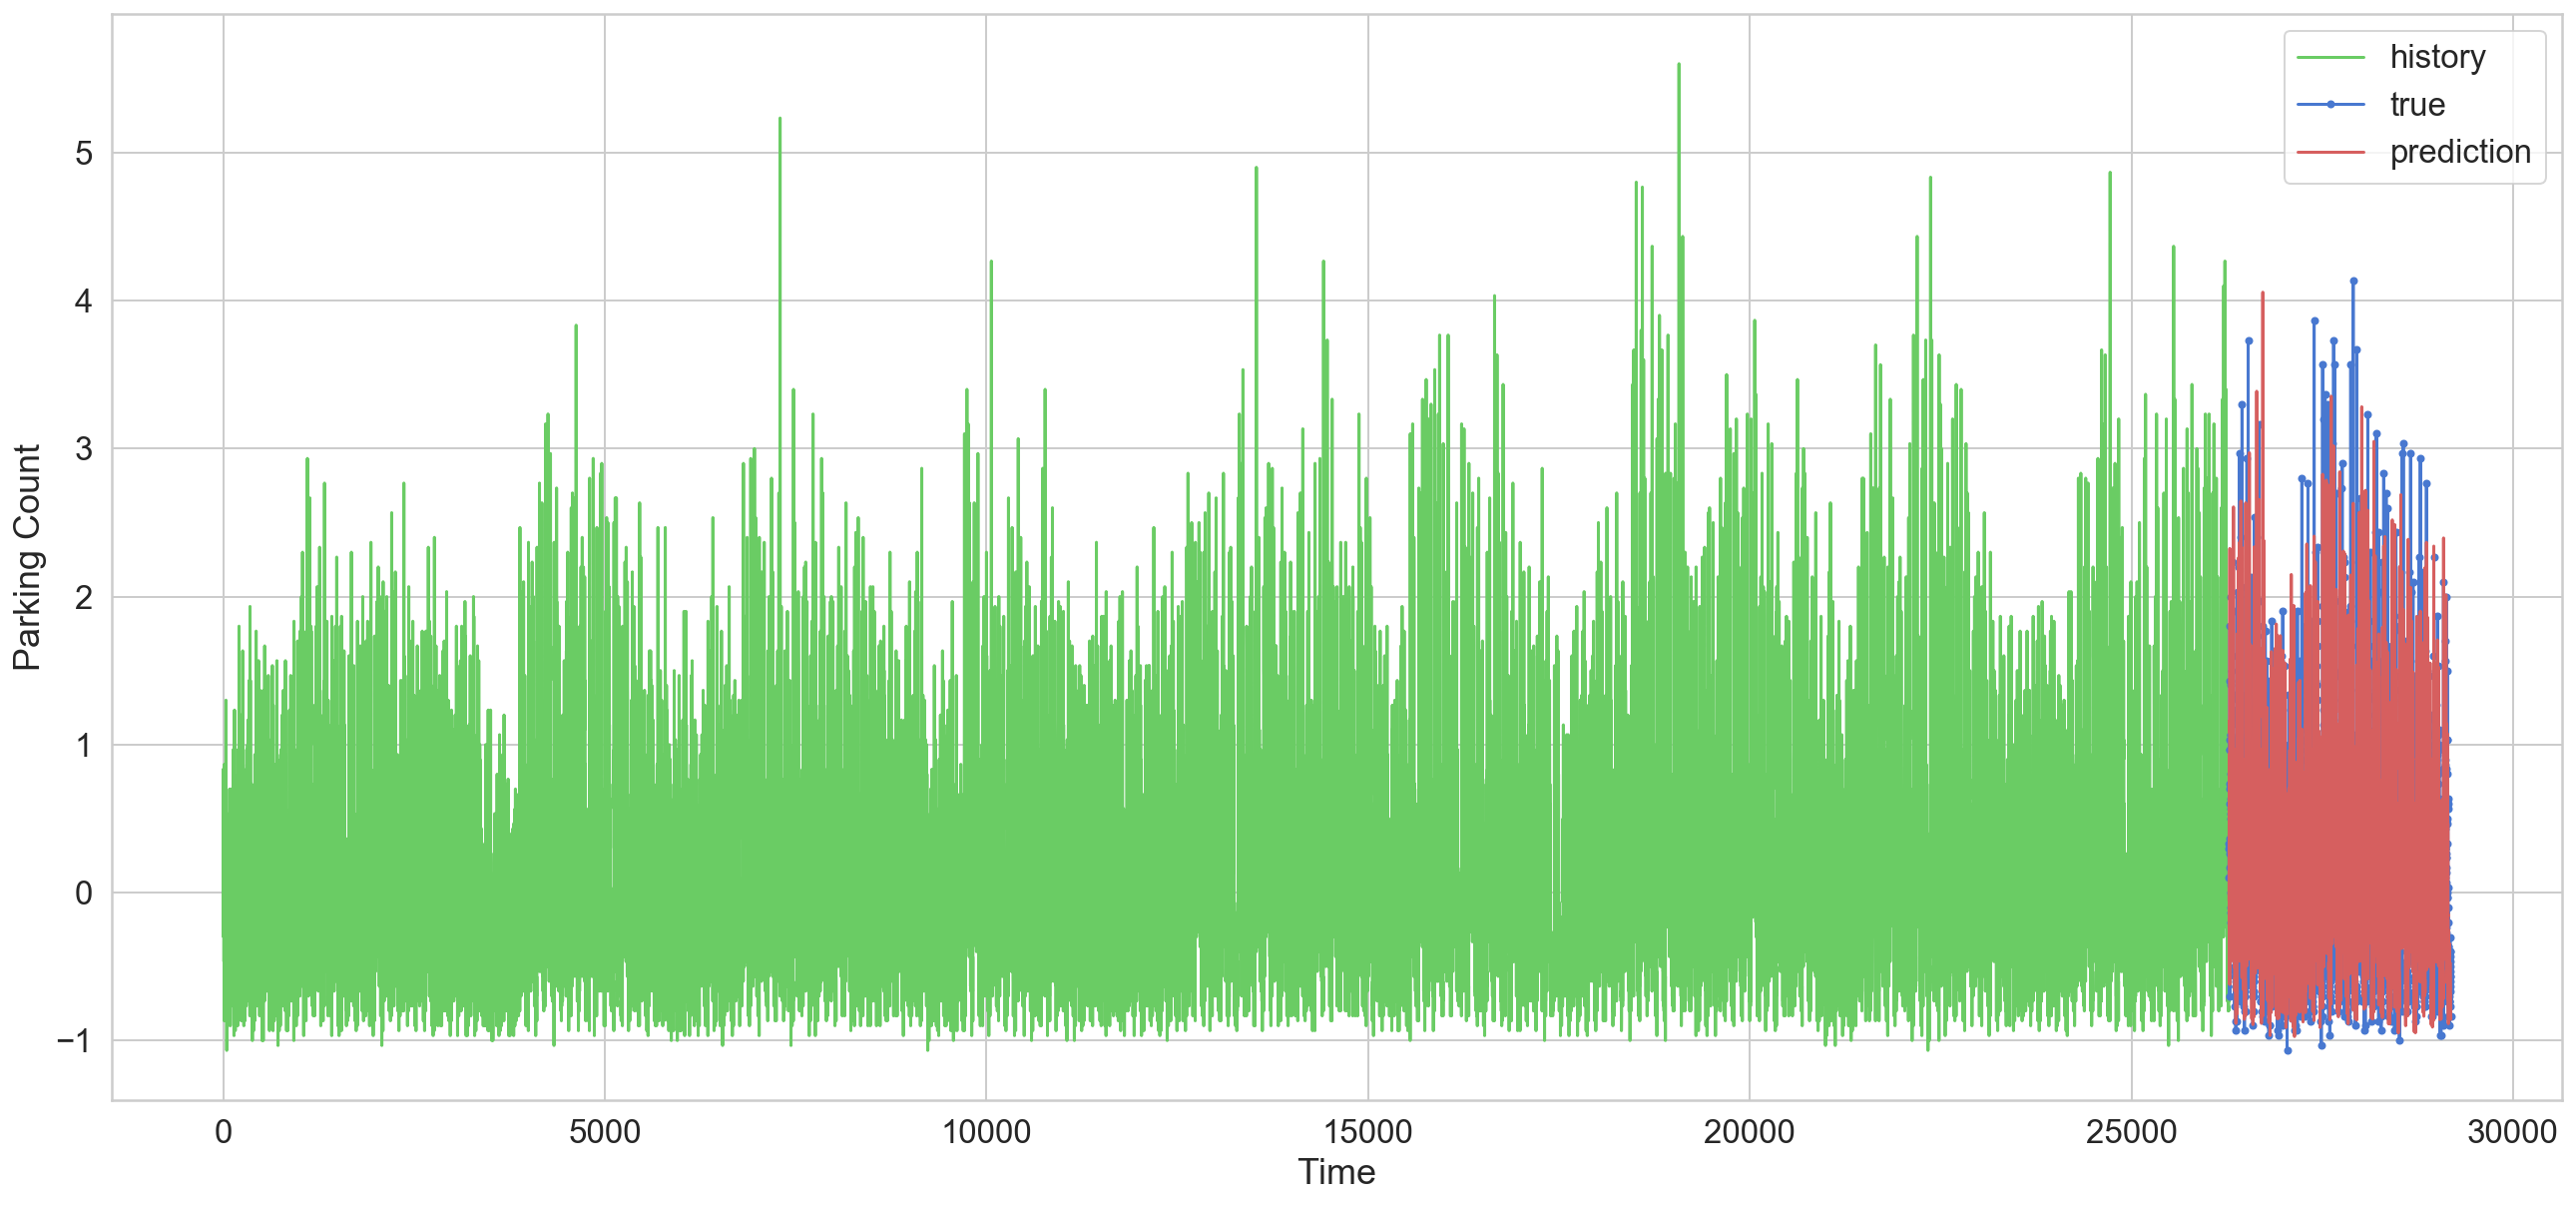

In [146]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Parking Count')
plt.xlabel('Time')
plt.legend()
plt.show();

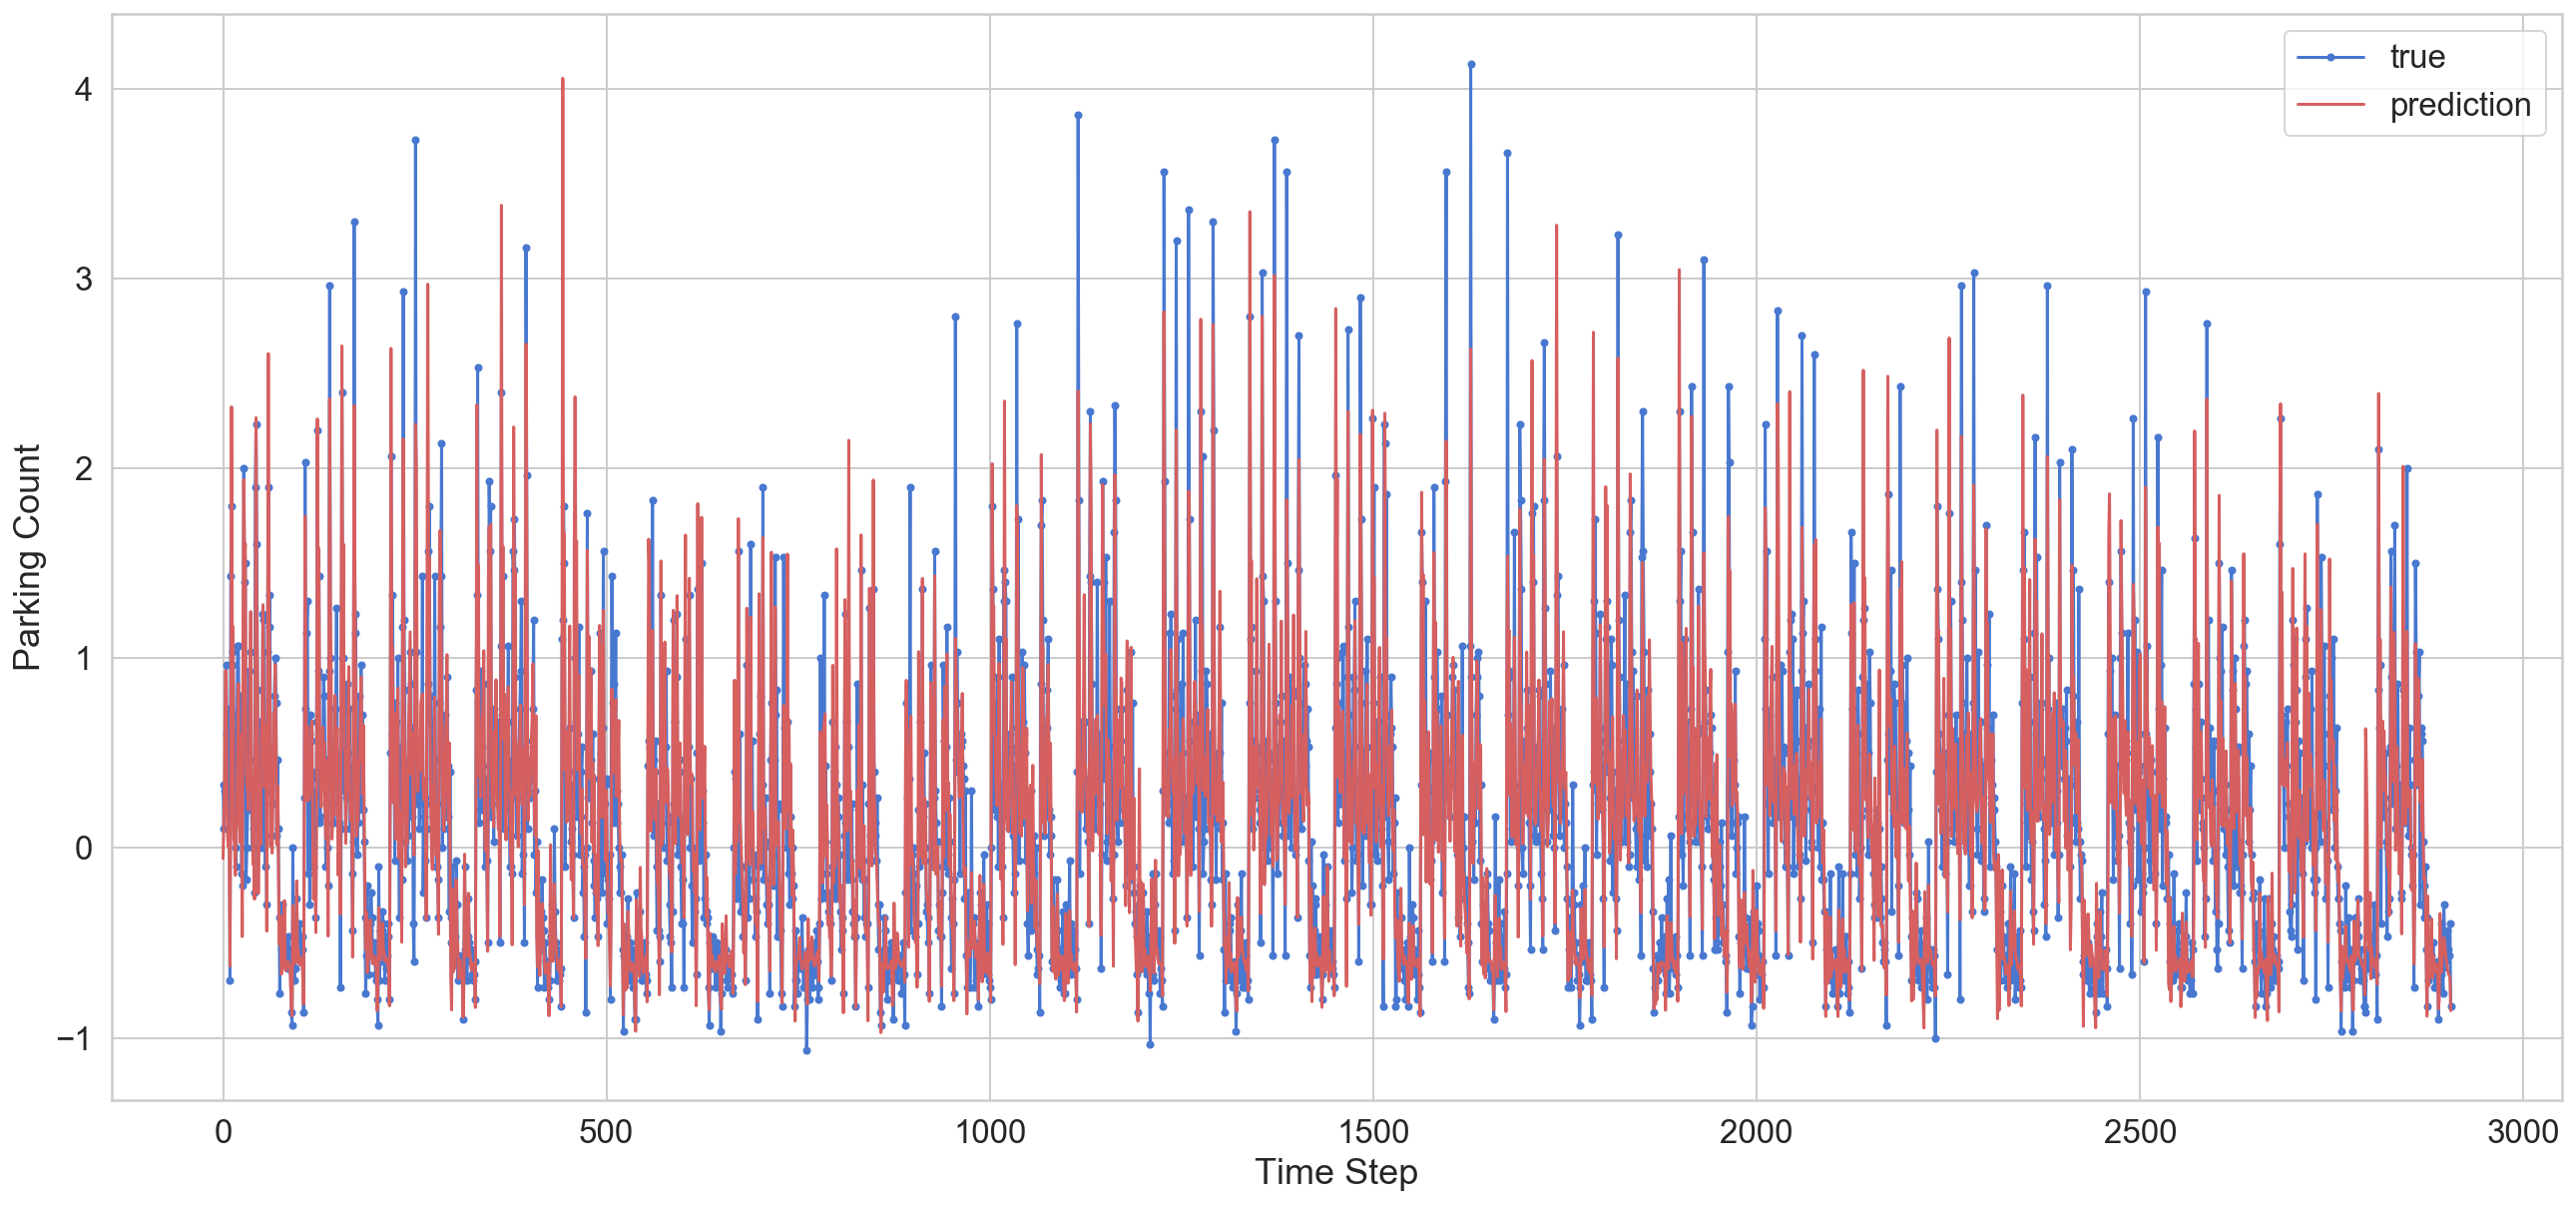

In [147]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Parking Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [148]:
savedf = pd.DataFrame(y_test_inv.flatten(), columns=['real'])
savedf['predict'] = y_pred_inv.flatten()
savedf['accuracy'] = savedf.apply((lambda x : (1 - abs(x['real'] - x['predict']) / x['real']) if x['real']>0 else 1),axis=1)
savedf

,real,predict,accuracy
0,0.333333,-0.055363,-0.166088
1,0.100000,0.134291,0.657085
2,0.300000,0.391180,0.696066
3,0.333333,0.931310,-0.793931
4,0.966667,0.934380,0.966600
...,...,...,...
2901,-0.433333,-0.645873,1.000000
2902,-0.533333,-0.661274,1.000000
2903,-0.566667,-0.672593,1.000000
2904,-0.400000,-0.683934,1.000000


In [135]:
model.save('model_multivariable_500epo_16timesteps') 
print("Done!")

Done!


In [124]:
new_model = tf.keras.models.load_model('model_multivariable_250epo_16timesteps')

# Check its architecture
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection multiple                  140288    
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  257       
Total params: 140,545
Trainable params: 140,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Export Dataset Above
print("Writing output file...")
savedf.to_csv('predict_with_accuracy.csv', index=True)
print("Done!")

In [136]:
print("Total Amount of Data Predicted: ", len(savedf))
print()
gt_95 = len(savedf[savedf['accuracy'] >= 0.95])
gt_90 = len(savedf[savedf['accuracy'] >= 0.90])
gt_75 = len(savedf[savedf['accuracy'] >= 0.75])
gt_low = len(savedf[savedf['accuracy'] < 0.75])
print("Predict Accuracy Greather Than 95%: ",gt_95, " - ", round((1 - ((abs((gt_95) - len(savedf))) / len(savedf)))*100,2),"% of the Total")
print("Predict Accuracy Greather Than 90%: ",gt_90, " - ", round((1 - ((abs((gt_90) - len(savedf))) / len(savedf)))*100,2),"% of the Total")
print()
print("Predict Accuracy Greather Than 75%: ",gt_75, " - ", round((1 - ((abs((gt_75) - len(savedf))) / len(savedf)))*100,2),"% of the Total")
print("Predict Accuracy Lower Than 75%: ",gt_low, " - ", round((1 - ((abs((gt_low) - len(savedf))) / len(savedf)))*100,2),"% of the Total")


Total Amount of Data Predicted:  2906

Predict Accuracy Greather Than 95%:  1494  -  51.41 % of the Total
Predict Accuracy Greather Than 90%:  1557  -  53.58 % of the Total

Predict Accuracy Greather Than 75%:  1801  -  61.98 % of the Total
Predict Accuracy Lower Than 75%:  1105  -  38.02 % of the Total
